## London Bike Sharing - EDA and Feature Engineering 

##### This analysis aims to understand what affects bike rentals in London and to explore the data. Additionally, a machine learning model will be developed to accurately predict the number of bike rentals based on factors such as time of day, day of the week, weather conditions, and season. By finding patterns, we hope to improve bike rental services in the city.

##### Import Libraries

In [223]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

##### Load Dataset

In [224]:
df = pd.read_csv('london_merged.csv')

##### Data Exploration and Preprocessing

In [225]:
#First 5 rows
df.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [226]:
#Shape of the dataset
df.shape

(17414, 10)

In [227]:
#Basic information about data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   timestamp     17414 non-null  object 
 1   cnt           17414 non-null  int64  
 2   t1            17414 non-null  float64
 3   t2            17414 non-null  float64
 4   hum           17414 non-null  float64
 5   wind_speed    17414 non-null  float64
 6   weather_code  17414 non-null  float64
 7   is_holiday    17414 non-null  float64
 8   is_weekend    17414 non-null  float64
 9   season        17414 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 1.3+ MB


In [228]:
#Check for missing values
df.isnull().sum()

timestamp       0
cnt             0
t1              0
t2              0
hum             0
wind_speed      0
weather_code    0
is_holiday      0
is_weekend      0
season          0
dtype: int64

In [229]:
# Convert categorical variables to integers
change_to_int = ['weather_code', 'season', 'is_holiday', 'is_weekend']
for col in change_to_int:
    df[col] = df[col].astype(int)

In [230]:
# Data Preparation
df['timestamp'] = pd.to_datetime(df['timestamp']) #Change data type to date-time
df['day_of_week'] = df['timestamp'].dt.dayofweek + 1  # Change index to start from Monday
df['hour'] = df['timestamp'].dt.hour

In [231]:
# Setting color theme for visuals
def set_color_map(color_list):
    return mcolors.LinearSegmentedColormap.from_list("custom_colormap", color_list)

color_list = ["#cd5c5c", "#feedca", "#755139", "#d2b48c", "#e97451", "#81422c","#efdecd"]
cmap_custom = set_color_map(color_list)

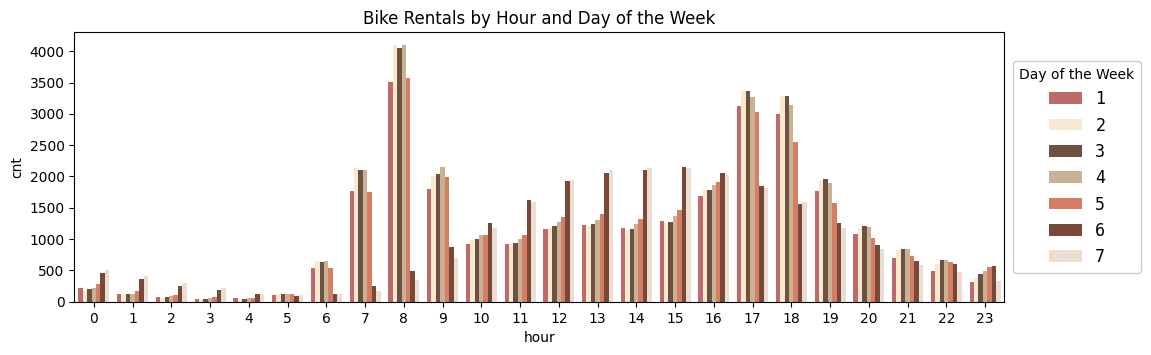

In [232]:
# Bike rentals by hour and day of the week
plt.figure(figsize=(12, 3.5))

sns.barplot(data=df, x='hour', y='cnt', hue='day_of_week', palette=cmap_custom, errorbar=None)
plt.title('Bike Rentals by Hour and Day of the Week')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), framealpha=1, prop={"size": "large", "family": "monospace"},title='Day of the Week')

plt.show()

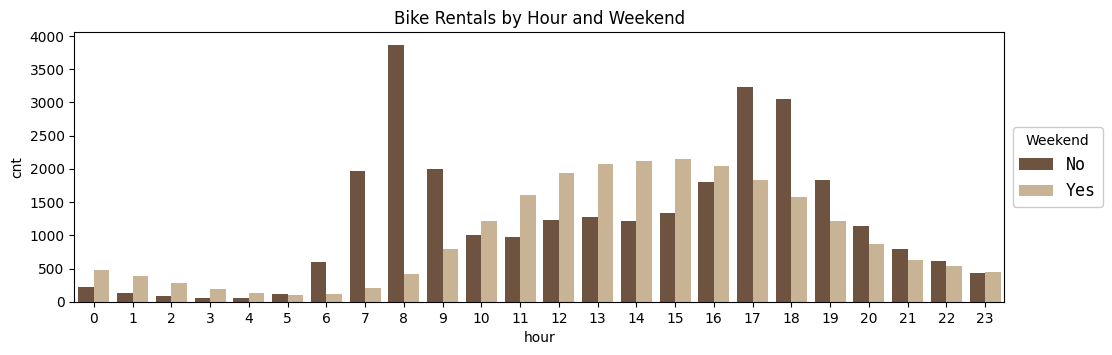

In [233]:
# Bike rentals by hour and weekend
plt.figure(figsize=(12, 3.5))
sns.barplot(data=df, x='hour', y='cnt', hue='is_weekend', palette=color_list[2:4], errorbar=None)
plt.title('Bike Rentals by Hour and Weekend')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), framealpha=1, prop={"size": "large", "family": "monospace"}, title='Weekend', labels=['No', 'Yes'])
plt.show()

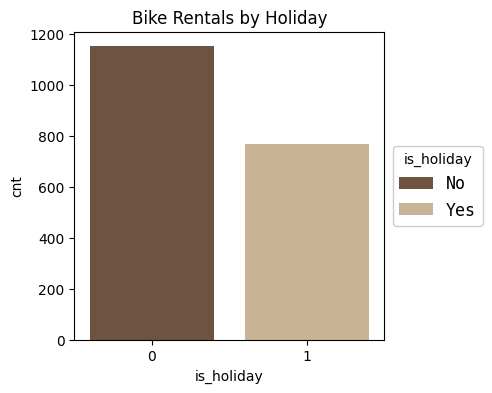

In [234]:
# Bike rentals by hour and weekend
plt.figure(figsize=(4,4))
sns.barplot(data=df, x='is_holiday', y='cnt', palette=color_list[2:4], errorbar=None)
plt.title('Bike Rentals by Holiday')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), framealpha=1, prop={"size": "large", "family": "monospace"}, title='is_holiday', labels=['No', 'Yes'])
plt.show()

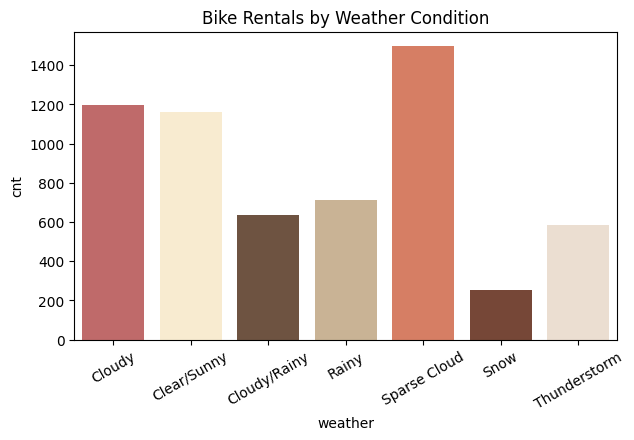

In [235]:
# Bike rentals by weather condition
plt.figure(figsize=(7, 4))
weather_map = {1.0: 'Clear/Sunny', 2.0: 'Sparse Cloud', 3.0: 'Cloudy', 4.0: 'Cloudy/Rainy', 7.0: 'Rainy',
               10.0: 'Thunderstorm', 26.0: 'Snow'}
df['weather'] = df['weather_code'].map(weather_map)
sns.barplot(data=df, x='weather', y='cnt',palette=color_list, errorbar=None)
plt.title('Bike Rentals by Weather Condition')
plt.xticks(rotation=30)
plt.show()

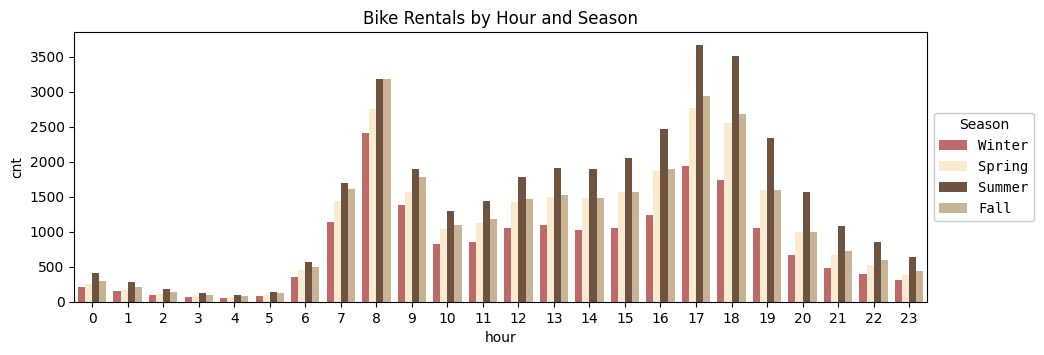

In [236]:
# Bike rentals by season and hour
plt.figure(figsize=(11, 3.5))
seasons = {0: 'Spring', 1: 'Summer', 2: 'Fall', 3: 'Winter'}
df['season_name'] = df['season'].map(seasons)
sns.barplot(data=df, x='hour', y='cnt', hue='season_name', palette=color_list[0:4], errorbar=None)
plt.title('Bike Rentals by Hour and Season')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), framealpha=1, prop={"size": "medium", "family": "monospace"}, title='Season')
plt.show()

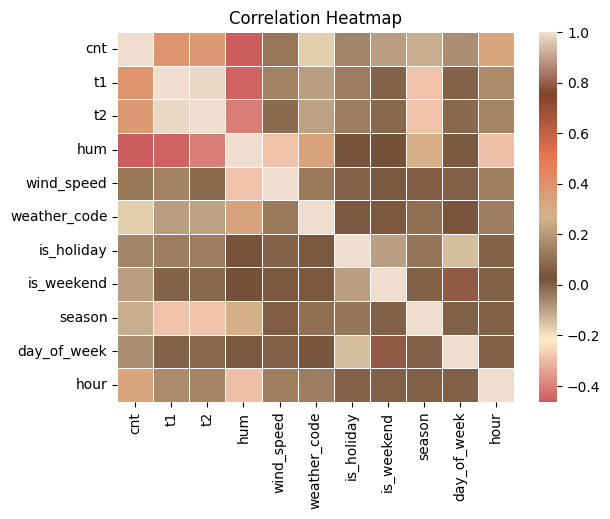

In [237]:
# Correlation Heatmap
numeric_df = df.select_dtypes(include=np.number)  # Select only numeric columns
corr = numeric_df.corr()  
sns.heatmap(corr, linewidths=0.5, cmap=cmap_custom)
plt.title('Correlation Heatmap')
plt.show()

In [238]:
# Mapping weather and season codes to descriptive categories
weather_map = {1: 'good', 2: 'great', 3: 'good', 4: 'rainy', 7: 'rainy', 10: 'rainy', 26: 'snowy'}
weather_map2 = {'great': 2, 'good': 1, 'rainy': -1, 'snowy': -2}
df['weather'] = df['weather_code'].map(weather_map)
df['weather'] = df['weather'].map(weather_map2)

seasons_map = {'Spring': 0, 'Summer': 1, 'Fall': 2, 'Winter': 3}
df['season'] = df['season_name'].map(seasons_map)

In [239]:
# Drop unnecessary columns
to_drop = ['timestamp','t2', 'season_name', 'weather_code']
df.drop(to_drop, axis=1, inplace=True)

In [240]:
# Check the mappings
df.head(2)

,cnt,t1,hum,wind_speed,is_holiday,is_weekend,season,day_of_week,hour,weather
0,182,3.0,93.0,6.0,0,1,3,7,0,1
1,138,3.0,93.0,5.0,0,1,3,7,1,1


##### Hypothesis Testing

Question: Does weather condition have an effect on the number of bike rentals?

Null Hypothesis (H0): There is no effect of weather condition on bike rentals.

Alternate Hypothesis (Ha): Weather condition significantly affects the number of bike rentals.

In [241]:
# Grouping data by weather condition and calculating mean rentals
weather_rentals = df.groupby('weather')['cnt'].mean()

# Printing mean rentals for each weather condition
print("Mean Rentals by Weather Condition:")
print(weather_rentals)

# Extracting rental data for each weather condition
good_weather = df[df['weather'] == 1]['cnt']
great_weather = df[df['weather'] == 2]['cnt']
rainy_weather = df[df['weather'] == -1]['cnt']
snowy_weather = df[df['weather'] == -2]['cnt']

# Performing ANOVA test
f_statistic, p_value = stats.f_oneway(good_weather, great_weather, rainy_weather, snowy_weather)

# Printing ANOVA test results
print("\nANOVA Test Results:")
print("F-Statistic:", f_statistic)
print("P-Value:", p_value)

# Making a decision based on the p-value
alpha = 0.05
if p_value < alpha:
    print("\nConclusion: Reject Null Hypothesis")
else:
    print("\nConclusion: Fail to reject Null Hypothesis")

Mean Rentals by Weather Condition:
weather
-2     250.850000
-1     681.018790
 1    1174.181425
 2    1496.177491
Name: cnt, dtype: float64

ANOVA Test Results:
F-Statistic: 403.45824881745085
P-Value: 2.1543351094584452e-253

Conclusion: Reject Null Hypothesis


The analysis rejects the null hypothesis, indicating that weather conditions significantly influence bike rentals.

##### Model Building

In [242]:
# Splitting data into features and target variable
y = df['cnt']
X = df.drop('cnt', axis=1)

In [243]:
# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##### Decision Tree

In [244]:
# Initialize and train the Decision Tree Regressor model
model = DecisionTreeRegressor()
model.fit(X_train, y_train)

DecisionTreeRegressor()

In [245]:
# Predict bike rentals on the test set
y_pred = model.predict(X_test)

In [246]:
# Evaluate model performance
mae_score = mean_absolute_error(y_test, y_pred)
print(f'The mean absolute error for the Decision Tree is: {round(mae_score, 2)}')

The mean absolute error for the Decision Tree is: 183.17


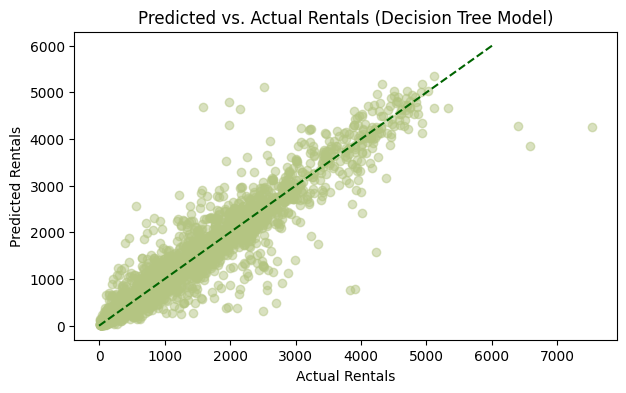

In [280]:
# Scatterplot to visualize predictions
plt.figure(figsize=(7, 4))
plt.scatter(y_test, y_pred, alpha=0.5, c="#b4c582")
plt.plot([0, 6000], [0, 6000], color='darkgreen', linestyle='--')
plt.xlabel('Actual Rentals')
plt.ylabel('Predicted Rentals')
plt.title('Predicted vs. Actual Rentals (Decision Tree Model)')
plt.show()

In [282]:
# Calculating RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)

# Calculating r-sq value
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

RMSE: 338.0403689747135
R-squared: 0.904634290695981


##### XGBoost

In [249]:
model_xg = XGBRegressor() 
model_xg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [251]:
# Making predictions
y_preds = model_xg.predict(X_test)

In [252]:
# Calculating RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_preds))
print("RMSE:", rmse)

r2_xgboost = r2_score(y_test, y_preds)
print("R-squared:", r2_xgboost)

RMSE: 243.32065954803537
R-squared: 0.9505902019142172


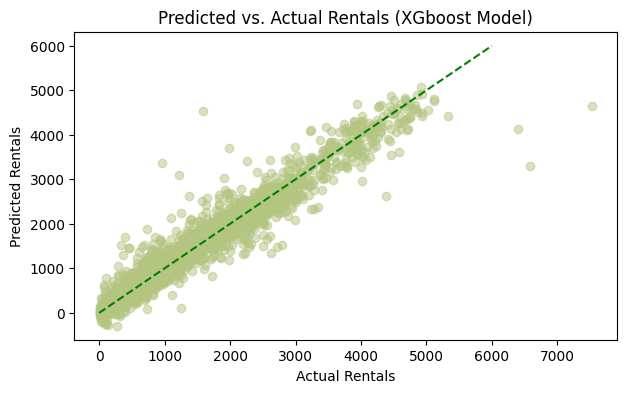

In [281]:
# Scatterplot to visualize predictions
plt.figure(figsize=(7, 4))
plt.scatter(y_test, y_preds, alpha=0.5, c="#b4c582")
plt.plot([0, 6000], [0, 6000], color='green', linestyle='--')
plt.xlabel('Actual Rentals')
plt.ylabel('Predicted Rentals')
plt.title('Predicted vs. Actual Rentals (XGboost Model)')
plt.show()

Based on both RMSE and R-squared values, the XGBoost model performs better than the Decision Tree model. It has a lower RMSE and a higher R-squared value, indicating that it is better at predicting the target variable and explaining the variance in the target variable. 

##### Conclusion

- There is a noticeable difference in rental patterns between holidays and regular weekdays. The count of bikes rented on working days significantly exceeds that on non-working days. During holidays, there is a noticeable decrease in bike rentals, suggesting that people tend to avoid riding bikes on such occasions.

- Weather conditions significantly affect bike rentals, with higher rentals observed during clear or cloudy weather compared to rainy or snowy conditions. Temperature also plays a role, with rentals rising progressively until a certain threshold and plateauing thereafter.

- Rental patterns vary across different seasons, with higher rentals observed during the summer months. Additionally, the analysis revealed distinct rental patterns associated with each season.

- The Decision Tree and XGBoost models were trained to predict bike rentals based on various features such as weather, time of day, and day of the week. Evaluation metrics such as RMSE and R-squared were used to assess model performance, with the XGBoost model demonstrating higher accuracy and better predictive power compared to the Decision Tree model.